# Quering an Web Service

In [4]:
import requests
result = requests.get("http://cat-fact.herokuapp.com/facts/random")
print(result)
print(result.json())
print(result.json()['text'])

<Response [200]>
{'used': False, 'source': 'api', 'type': 'cat', 'deleted': False, '_id': '591f9894d369931519ce358b', '__v': 0, 'text': 'Cats lose almost as much fluid in the saliva while grooming themselves as they do through urination.', 'updatedAt': '2020-08-23T20:20:01.611Z', 'createdAt': '2018-04-26T20:20:02.740Z', 'status': {'verified': True, 'sentCount': 1}, 'user': '5a9ac18c7478810ea6c06381'}
Cats lose almost as much fluid in the saliva while grooming themselves as they do through urination.


# Quering the echo Service

After running the echo.py service implemented using flask here is how to make requests to it:

In [6]:
import requests
result = requests.get("http://3.14.81.252:5000/?msg=HelloWorld!")
print(result.json())

{'response': 'HelloWorld!', 'success': True}


In [10]:
result = requests.get("http://3.14.81.252:5000/",params={"msg":"Hello from params"})
print(result.json())

{'response': 'HelloWorld!', 'success': True}


In [25]:
result = requests.post("http://3.14.81.252:5000/",params={"msg":"Hello from data"})
print(result.json())

{'response': 'Hello from data', 'success': True}


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64

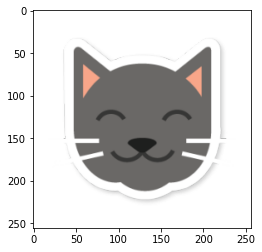

In [27]:
image = open("luna.png","rb").read()
encoded = base64.b64encode(image)
result = requests.post("http://3.14.81.252:5000/",
                    params={'msg':encoded})
encoded = result.json()['response']
imgData = base64.b64decode(encoded)
plt.imshow(np.array(Image.open(io.BytesIO(imgData))))

## Deploying a Models in a web service

### Sklearn Models

In [28]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
df = pd.read_csv("https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv")

X = df.drop(['label'],axis=1)
y = df['label']

model = LogisticRegression()
model.fit(X,y)

LogisticRegression()

#### Using Pickle

In [2]:
import pickle
with open("logit.pkl","wb") as file:
    pickle.dump(model, file)

In [3]:
with open("logit.pkl","rb") as file:
    model = pickle.load(file)
    print(model.predict_proba(X)[:2])

[[0.93124982 0.06875018]
 [0.86491573 0.13508427]]


#### Using MLFlow

In [4]:
import mlflow
import shutil

model_path = "models/logit_games_v1"
shutil.rmtree(model_path)
mlflow.sklearn.save_model(model, model_path)

In [5]:
loaded = mlflow.sklearn.load_model(model_path)
loaded.predict_proba(X[:2])

/root/.local/share/virtualenvs/mlops-sKEcTriU/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427]])

## Keras

In [51]:
import tensorflow as tf

In [52]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                   ])

We can define our coustume functions as saving them. This implementation idea from [here](https://towardsdatascience.com/custom-metrics-in-keras-and-how-simple-they-are-to-use-in-tensorflow2-2-6d079c2ca279) or run ``tf.keras.metrics.Metric?`` To see a simple example of implementation. Another alternative without Metric class inheritance is [this](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)

In [70]:
class F1Metric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes=2, name='f1_score', **kwargs):
        super(F1Metric, self).__init__(name=name, **kwargs)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return f1[0]

In [66]:
#Second alternative:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Note:** Check why this two are different!

In [77]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC(), f1_m, F1Metric()])

In [78]:
history = model.fit(X, y, epochs=10, batch_size=100, validation_split=0.2)

Epoch 1/10
184/184 [==============================] - 1s 4ms/step - loss: 0.3142 - auc_3: 0.8159 - f1_m: 0.2556 - f1_score: 0.9269 - val_loss: 0.2939 - val_auc_3: 0.8183 - val_f1_m: 0.0093 - val_f1_score: 0.9376
Epoch 2/10
184/184 [==============================] - 0s 2ms/step - loss: 0.3141 - auc_3: 0.8148 - f1_m: 0.2565 - f1_score: 0.9269 - val_loss: 0.2894 - val_auc_3: 0.8185 - val_f1_m: 0.0070 - val_f1_score: 0.9376
Epoch 3/10
184/184 [==============================] - 1s 3ms/step - loss: 0.3136 - auc_3: 0.8163 - f1_m: 0.2627 - f1_score: 0.9269 - val_loss: 0.2861 - val_auc_3: 0.8255 - val_f1_m: 0.0024 - val_f1_score: 0.9376
Epoch 4/10
184/184 [==============================] - 0s 2ms/step - loss: 0.3145 - auc_3: 0.8149 - f1_m: 0.2554 - f1_score: 0.9269 - val_loss: 0.2876 - val_auc_3: 0.8186 - val_f1_m: 0.0093 - val_f1_score: 0.9376
Epoch 5/10
184/184 [==============================] - 0s 2ms/step - loss: 0.3134 - auc_3: 0.8179 - f1_m: 0.2612 - f1_score: 0.9269 - val_loss: 0.2877 - 

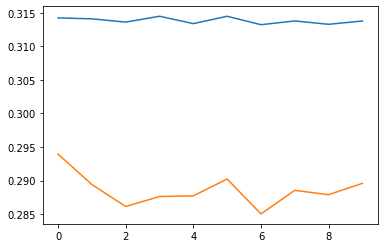

In [79]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

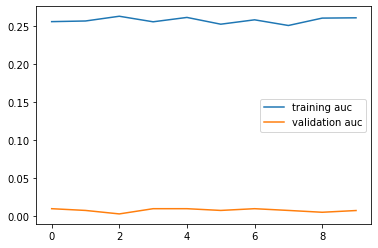

In [80]:
plt.plot(history.history['f1_m'], label='training auc')
plt.plot(history.history['val_f1_m'], label='validation auc')
plt.legend()

### Saving the model using Keras

We can save this model using keras, however to load it we will need the custom metrics we define

In [81]:
model.save("games.h5")

In [82]:
tf.keras.models.load_model("games.h5",custom_objects={'f1_m':f1_m, "F1Metric":F1Metric})

In [85]:
model.evaluate(X,y)

716/716 [==============================] - 1s 1ms/step - loss: 0.3065 - auc_3: 0.8185 - f1_m: 0.1466 - f1_score: 0.9290


[0.3065178692340851,
 0.8185286521911621,
 0.1466277837753296,
 0.9290223121643066]

### Saving the model Using MLflow

In [93]:
rm -rf /mlops/notebooks/models/keras_games_v1

In [94]:
import mlflow.keras
model_path = "models/keras_games_v1"
mlflow.keras.save_model(model, model_path)
loaded = mlflow.keras.load_model(model_path,
custom_objects={'f1_m':f1_m, "F1Metric":F1Metric})
loaded.evaluate(X, y, verbose = 0)

[0.3065178692340851,
 0.8185286521911621,
 0.1466277837753296,
 0.9290223121643066]